# 2021 TensorFlow 勉強用

## 手順(1) 「ans_studyInput_fork.txt」をアップロード

In [54]:
 # Colaboratoryでファイルをアップロード
 from google.colab import files
 uploaded = files.upload()

In [55]:
import pandas as pd
df_study = pd.read_csv('ans_studyInput_qa.txt', names=['id', 'truth_val', 'ラベル（教師データ）', '入力'])
df_study

,id,truth_val,ラベル（教師データ）,入力
0,1,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金はいくら？
1,2,T,"チャージ料金 1500円また,アルコール類を500円""より提供しております。[こちら](ht...",金額はどのくらいかかる？
2,3,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,いくらあれば足りる？
3,x,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金を教えてください
4,x,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金について
...,...,...,...,...
160,x,T,「人生とは何か？」「生きることに意味はあるのか？」 引っ越しや家を買うタイミングは、人生につ...,人生について教えて？
161,x,T,「人生とは何か？」「生きることに意味はあるのか？」 引っ越しや家を買うタイミングは、人生につ...,生きていくにはどうすればよい？
162,x,T,辞書で定義される「愛」には、様々な意味があります。よく使われる意味は「親子、兄弟がお互いをい...,愛とは何ですか？
163,x,T,辞書で定義される「愛」には、様々な意味があります。よく使われる意味は「親子、兄弟がお互いをい...,愛するとは


## 手順(2) 保存用ディレクトリ、必要なライブラリをインストール

In [56]:
# 入力ファイル用のディレクトリ作成
!mkdir text
# 必要なライブラリをインストール
!apt-get install mecab libmecab-dev mecab-ipadic-utf8
!pip3 install mecab-python3==0.996.5 tensorflow==2.5.0

mkdir: cannot create directory ‘text’: File exists
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
mecab is already the newest version (0.996-5).
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [57]:
!ls -ltra

total 64
drwxr-xr-x 4 root root  4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root  4096 Dec  3 14:33 sample_data
drwxr-xr-x 1 root root  4096 Dec 12 02:32 ..
drwxr-xr-x 2 root root  4096 Dec 12 02:37 text
drwxr-xr-x 2 root root  4096 Dec 12 04:58 .ipynb_checkpoints
-rw-r--r-- 1 root root 38651 Dec 12 04:58 ans_studyInput_qa.txt
drwxr-xr-x 1 root root  4096 Dec 12 04:59 .


In [ ]:
 !rm ans_studyInput_qa.txt
 # Colaboratoryでファイルをアップロード
 from google.colab import files
 uploaded = files.upload()

Saving ans_studyInput_fork.txt to ans_studyInput_fork.txt


## 手順(4)  学習データ（DB）を作成

In [58]:
import MeCab

tagger = MeCab.Tagger('-d /etc/alternatives/mecab-dictionary')

def tokenize(text):
    '''MeCabで形態素解析を行う''' # --- (*3)
    result = []
    word_s = tagger.parse(text)
    # print(word_s)
    for n in word_s.split("\n"):
        if n == 'EOS' or n == '': continue
        p = n.split("\t")[1].split(",")
        h, h2, org = (p[0], p[1], p[6])
        if not (h in ['名詞', '動詞', '形容詞']): continue
        if h == '名詞' and h2 == '数': continue
        if org == '*': org = n.split("\t")[0]
        result.append(org)
    # return result
    return ' '.join(result)

In [60]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# csvファイルを読み込む
def main():
    # ファイル一覧を読む --- (*2)　目的により変える！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    df_study = pd.read_csv('ans_studyInput_qa.txt', names=['id', 'truth_val', 'ans', 'que'])
    # df_study = pd.read_csv('ans_studyInput_fork.txt', names=['id', 'truth_val', 'ans', 'que'])

    labelToCode = {lbl:idx for idx, lbl in enumerate(df_study.ans.unique())}
    y = df_study.ans.apply(lambda x: labelToCode[x]).tolist()

    # tfidを計算
    df_wakati = df_study["que"].apply(lambda x: tokenize(x))
    vectorizer = TfidfVectorizer(max_df=0.9, token_pattern='(?u)\\b\\w+\\b') # tf-idfの計算 1文字でもOK
    x = vectorizer.fit_transform(df_wakati).toarray()

    # オブジェクト類（tfid等）を保存
    pickle.dump(vectorizer, open('text/tfidf_vec.pickle', 'wb'))
    pickle.dump([y, x], open('text/genre.pickle', 'wb'))
    pickle.dump(labelToCode, open('text/label_to_code.pickle', 'wb'))

    print(df_study)

# 実行
if __name__ == '__main__':
    main()

    id  ...              que
0    1  ...          料金はいくら？
1    2  ...     金額はどのくらいかかる？
2    3  ...       いくらあれば足りる？
3    x  ...       料金を教えてください
4    x  ...           料金について
..  ..  ...              ...
160  x  ...       人生について教えて？
161  x  ...  生きていくにはどうすればよい？
162  x  ...         愛とは何ですか？
163  x  ...            愛するとは
164  x  ...         愛について教えて

[165 rows x 4 columns]


## 手順(5)  学習モデルを作成

In [61]:
import pickle
import tensorflow as tf


# 分類するラベルの数
labelToCode = pickle.load(open("text/label_to_code.pickle", "rb"))
nb_classes = len(labelToCode) 

# データベースの読込
data = pickle.load(open("text/genre.pickle", "rb"))
x = data[1] # TF-IDF

# 入力x[0]の要素数（TF-IDF）より入力要素数を求める
in_size = x[0].shape[0]

# MLPモデル構造を定義
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(in_size,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax))

# モデルをコンパイル
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

input_shape = x.shape
print(input_shape)
# model.build((input_shape)) # `input_shape` is the shape of the input data
#                          # e.g. input_shape = (None, 32, 32, 3)
model.summary()

# モデルを保存する
model.save('text/hw_model.h5')
print('model seved')

(165, 150)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               77312     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 33)                16929     
Total params: 356,897
Trainable params: 356,897
Non-trainable params: 0
_________________________________________________________________
model seved


## 手順(6)  学習（MLP）を実行

Epoch 1/300
5/5 [==============================] - 1s 42ms/step - loss: 3.4574 - accuracy: 0.1364 - val_loss: 3.4272 - val_accuracy: 0.0303
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 3.2580 - accuracy: 0.1364 - val_loss: 3.3707 - val_accuracy: 0.0303
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 3.0750 - accuracy: 0.2045 - val_loss: 3.3157 - val_accuracy: 0.0606
Epoch 4/300
5/5 [==============================] - 0s 10ms/step - loss: 2.8712 - accuracy: 0.3030 - val_loss: 3.2045 - val_accuracy: 0.0909
Epoch 5/300
5/5 [==============================] - 0s 9ms/step - loss: 2.6340 - accuracy: 0.4091 - val_loss: 3.1149 - val_accuracy: 0.1515
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 2.4115 - accuracy: 0.5076 - val_loss: 3.0144 - val_accuracy: 0.3333
Epoch 7/300
5/5 [==============================] - 0s 9ms/step - loss: 2.1697 - accuracy: 0.6970 - val_loss: 2.8629 - val_accuracy: 0.3030
Epoch 8/300
5/5 [=====

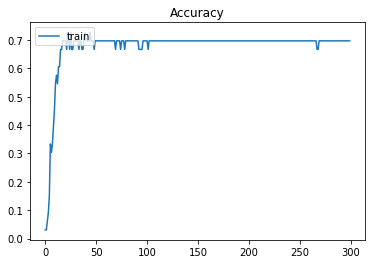

In [62]:
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os


# 分類するラベルの数
labelToCode = pickle.load(open("text/label_to_code.pickle", "rb"))
nb_classes = len(labelToCode) 

# データベースの読込
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0] # ラベルコード
x = data[1] # TF-IDF

# ラベルデータをone-hotベクトルに直す
y = tf.keras.utils.to_categorical(y, nb_classes)
in_size = x[0].shape[0] # 入力x[0]の要素数

# 学習用とテスト用を分ける
x_train, x_test, y_train, y_test = train_test_split(
        np.array(x), np.array(y), test_size=0.2)

# モデルを読み込む
model = tf.keras.models.load_model('text/hw_model.h5')

# 既に学習済みの重みデータが存在していれば読み込む
# if os.path.exists(ml_dir + 'text/hw_weights.h5'):
#     model.load_weights(ml_dir + 'text/hw_weights.h5')

# 学習を実行
hist = model.fit(x_train, y_train,
          batch_size=30, # 1回に計算するデータ数
          epochs=300,    # 学習の繰り返し回数みたいなもの
          verbose=1,
          validation_data=(x_test, y_test))

# 評価する
score = model.evaluate(x_test, y_test, verbose=1)
print("正解率=", score[1], 'loss=', score[0])

# 重みデータを保存
model.save_weights('text/hw_weights.h5')

# 学習の様子をグラフへ描画
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 手順(7)  学習（MLP）モデルを実行して、判定

In [64]:
import pickle
import tensorflow as tf
# import pandas as pd


def inverse_dict(d):
    return {v:k for k,v in d.items()}

# モデルを読み込む
model = tf.keras.models.load_model('text/hw_model.h5')
# 学習済みの重みデータを読み込む
model.load_weights('text/hw_weights.h5')
# tfidオブジェクトをファイルよりロードする
vectorizer_loaded = pickle.load(open("text/tfidf_vec.pickle", "rb"))
# ラベルの定義
labelToCode = pickle.load(open("text/label_to_code.pickle", "rb"))
label_dic = inverse_dict(labelToCode)

# テキストを指定して判定
def predCatego(text):
    # TF-IDFのベクトルに変換 
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    # MLPで予測
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    maxInd = sortIndexDesc[0]
    ans_sentence = label_dic[maxInd]
    predict_val = "{:.4f}".format(pre[maxInd])

    print(ans_sentence, predict_val)
    print("2番目の答え : " + label_dic[sortIndexDesc[1]], "{:.4f}".format(pre[sortIndexDesc[1]]))
    return ans_sentence, predict_val

if __name__ == '__main__':
    requestParam = """
    コロナ対策について教えてください？
    """
    predCatego(requestParam)

お客様にご安心してご利用いただけるよう、換気設備を導入致しました。約4分で店内の空気が入れ替わり、新型コロナウィルス対策を徹底しております。また、店内の消毒、ビニールシートなど様々な対策を行っています。 1.0000
2番目の答え : サイト内に楽曲を紹介しているのでサイトマップから探してみてください。[こちら](https://nango7.okbmk.com/nango/rt/play_music_info_nango_temp) 0.0000


## 手順(8)  デプロイに必要な学習済みデータをダウンロード

In [ ]:
! zip -r res text/
from google.colab import files
files.download('res.zip')

#その他 テストコード

In [71]:
import requests
import json

# お勧めの曲データを取得する
# HOW_MUSIC_WORD = "中島みゆきが歌う曲で人との出会いがテーマの曲"
HOW_MUSIC_WORD = "スピッツが歌っててテーマが青春の曲を教えて"
url =f'http://52.192.175.215:8888/recommend/api/what-music/{HOW_MUSIC_WORD}'
response = requests.get(url)
response.raise_for_status()

music_data = json.loads(response.text)
w = music_data['recoMusicInfos']

recMusic = w[0]['recoMusicMoji']

print(recMusic)

空も飛べるはず


In [72]:
import re

phone_regex = re.compile(r'\d\d\d-\d\d\d-\d\d\d')

mo = phone_regex.search("電話番号は123-456-789です。")

print(mo.group())


maru_phone_regex = re.compile(r'(\d\d\d)-(\d\d\d-\d\d\d)')
maru_mo = maru_phone_regex.search("電話番号は321-956-389です。")

print(maru_mo.group(1))

123-456-789
321
